In [2]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from utility.visualization_utility import create_mat_plot
from utility.math_utility import generate_binary
from utility.list_set_util import get_intersection_of_list
import itertools
import numpy as np


## Getting significant features from all methods

In [3]:
features_addresses={'Random Forest':'../../amr_results/5_3_2017/classifications_standard/##drug##gpa_trimmed_gpa_roaryRF_features', 'Chi2':'../../amr_results/res_before_5_3_2017/results/feature_selection/chi2/##drug##gpa_trimmed_gpa_roary','PhyloChi':'/mounts/data/proj/asgari/dissertation/git_repos/amr_results/features/phylochi2/gpa_trimmed_gpa_roary##drug##.txt','SVM':'../../amr_results/features/gpa/##drug##_S-vs-R_non-zero+weights.txt','Treewas':'../../amr_results/features/treewas/gpa/##drug##_S.vs.R_terminal_p-vals_name.txt'}


def generate_feature_sets(features_addresses):
    '''
        Final all features
    '''
    methods=list(features_addresses.keys())
    methods.sort()
    res=dict()
    for drug in ['Ciprofloxacin', 'Tobramycin', 'Colistin', 'Ceftazidim', 'Meropenem']:
        res[drug]=dict()
        for idx,method in enumerate(methods):
            if method=='Random Forest' or method=='SVM':
                res[drug][method]=dict([(x.split('\t')[0].replace(' ','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[method].replace('##drug##',drug))[1::]])
            if method=='Chi2' or method=='PhyloChi':
                res[drug][method]=dict([(x.split('\t')[0].replace(' ','').replace('gain_','').replace('loss_','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[method].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) > 10 ])
            if method=='Treewas':
                res[drug][method]=dict([(x.split('\t')[0].replace(' ',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[method].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) < 0.05 ])
    return res

def generate_intersection_matrix(features_addresses, drug):
    '''
        This function generates intersection table for all methods for a given drug
    '''
    methods=list(features_addresses.keys())
    methods.sort()
    method_pairs=list(itertools.combinations(range(len(methods)),2))+[(x,x) for x in range(len(methods))]
    mat=np.zeros((len(methods),len(methods)))
    for idx,idy in method_pairs:
        if methods[idx]=='Random Forest' or methods[idx]=='SVM':
            residx=dict([(x.split('\t')[0].replace(' ','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idx]].replace('##drug##',drug))[1::]])
        if methods[idy]=='Random Forest' or methods[idy]=='SVM':
            residy=dict([(x.split('\t')[0].replace(' ','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idy]].replace('##drug##',drug))[1::]])
        if methods[idx]=='Chi2' or methods[idx]=='PhyloChi':
            residx=dict([(x.split('\t')[0].replace(' ','').replace('gain_','').replace('loss_','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idx]].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) > 4 ])
        if methods[idy]=='Chi2' or methods[idy]=='PhyloChi':
            residy=dict([(x.split('\t')[0].replace(' ','').replace('gain_','').replace('loss_','').replace('gpa_roary##','').replace('gpa_trimmed##',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idy]].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) > 4])
        if methods[idx]=='Treewas':
            residx=dict([(x.split('\t')[0].replace(' ',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idx]].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) < 0.05 ])
        if methods[idy]=='Treewas':
            residy=dict([(x.split('\t')[0].replace(' ',''),float(x.split('\t')[1])) for x in FileUtility.load_list(features_addresses[methods[idy]].replace('##drug##',drug))[1::] if float(x.split('\t')[1]) < 0.05])
        mat[idx,idy]=len(set(residx.keys()).intersection(residy.keys()))
        mat[idy,idx]=mat[idx,idy]
    return mat, methods

In [4]:
drug_method_features_scores_dict=generate_feature_sets(features_addresses)

In [17]:
# intersection of all
for drug, y in  drug_method_features_scores_dict.items():
    print (drug)
    print (len(get_intersection_of_list([feature for method,feature in y.items()])))

Ciprofloxacin
1
Tobramycin
5
Meropenem
3
Ceftazidim
1
Colistin
3


## Venns diagram

In [5]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import matplotlib
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline 

def methods2venn(res_dict, name=None):
    '''
        Plot the overlap of sets in the dictionary
        return: accumulative of all intersections > 1
    '''
    all_methods=list(res_dict.keys())
    all_methods.sort()
    figure(figsize=(50,20))
    threesets=list(itertools.combinations(all_methods,3))
    final_list=[]
    for idx,methods in enumerate(threesets):
        methods=list(methods)
        methods.sort()
        binary_sets=generate_binary(len(methods))
        subsets_sizes=tuple([len(get_intersection_of_list([list(res_dict[methods[idx]].keys())  for idx,x in enumerate(list(setting))  if x=='1' ])) for setting in binary_sets])
        at_least_intersection=[x for x in binary_sets if x.count('1')>1]
        final_list+=list(itertools.chain(*[get_intersection_of_list([list(res_dict[methods[idx]].keys())  for idx,x in enumerate(list(setting))  if x=='1' ]) for setting in at_least_intersection]))
        subplot(2,5,idx+1)
        v = venn3(subsets=subsets_sizes, set_labels=tuple(methods))
    plt.tight_layout()
    plt.show()
    if name:
        plt.savefig(name+'.pdf', dpi=500)
    return final_list

Populating the interactive namespace from numpy and matplotlib


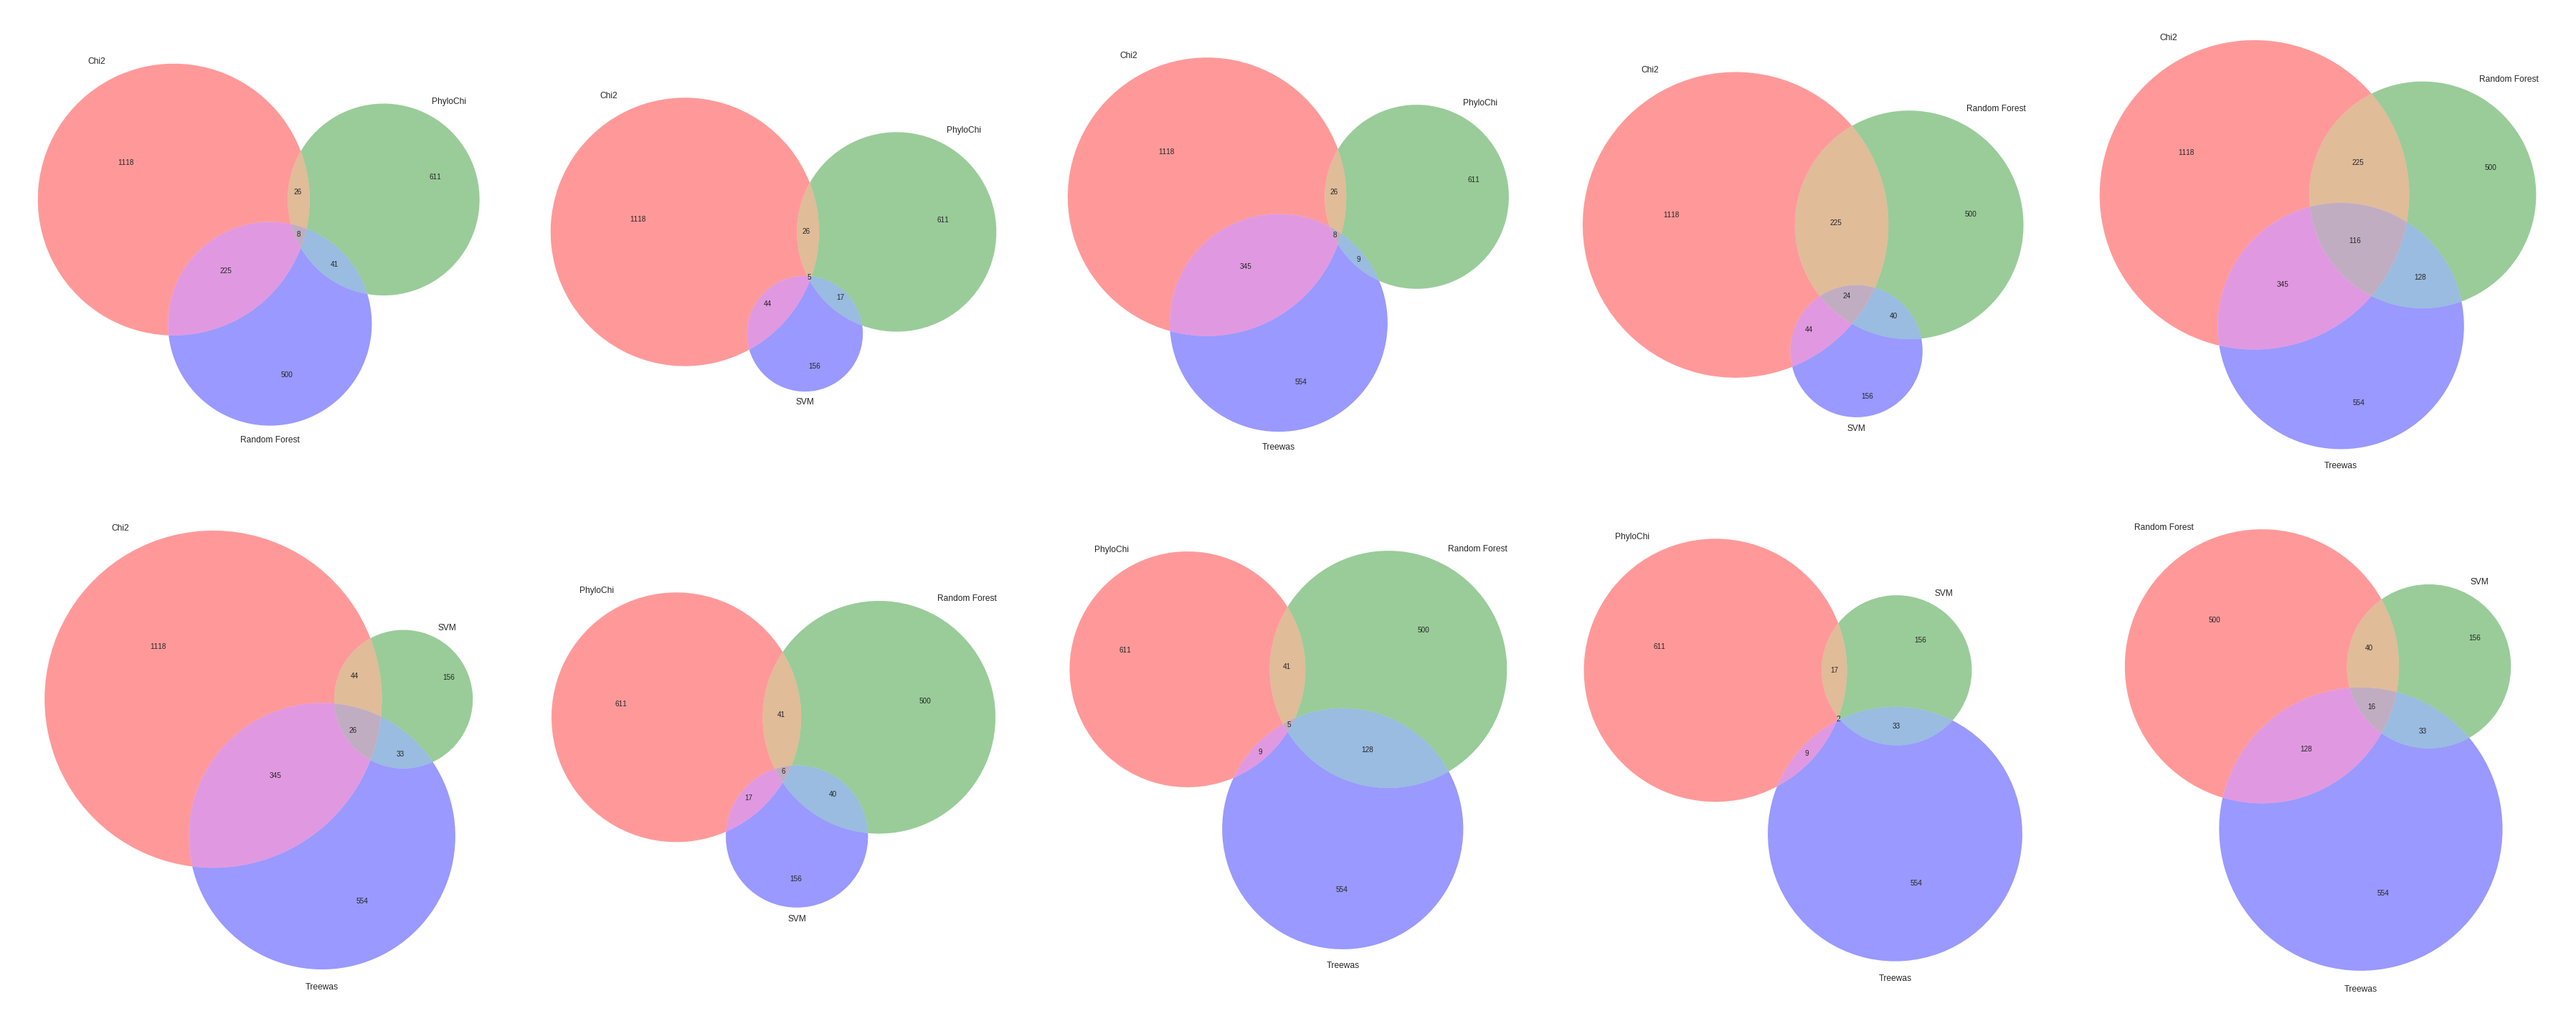

Ciprofloxacin


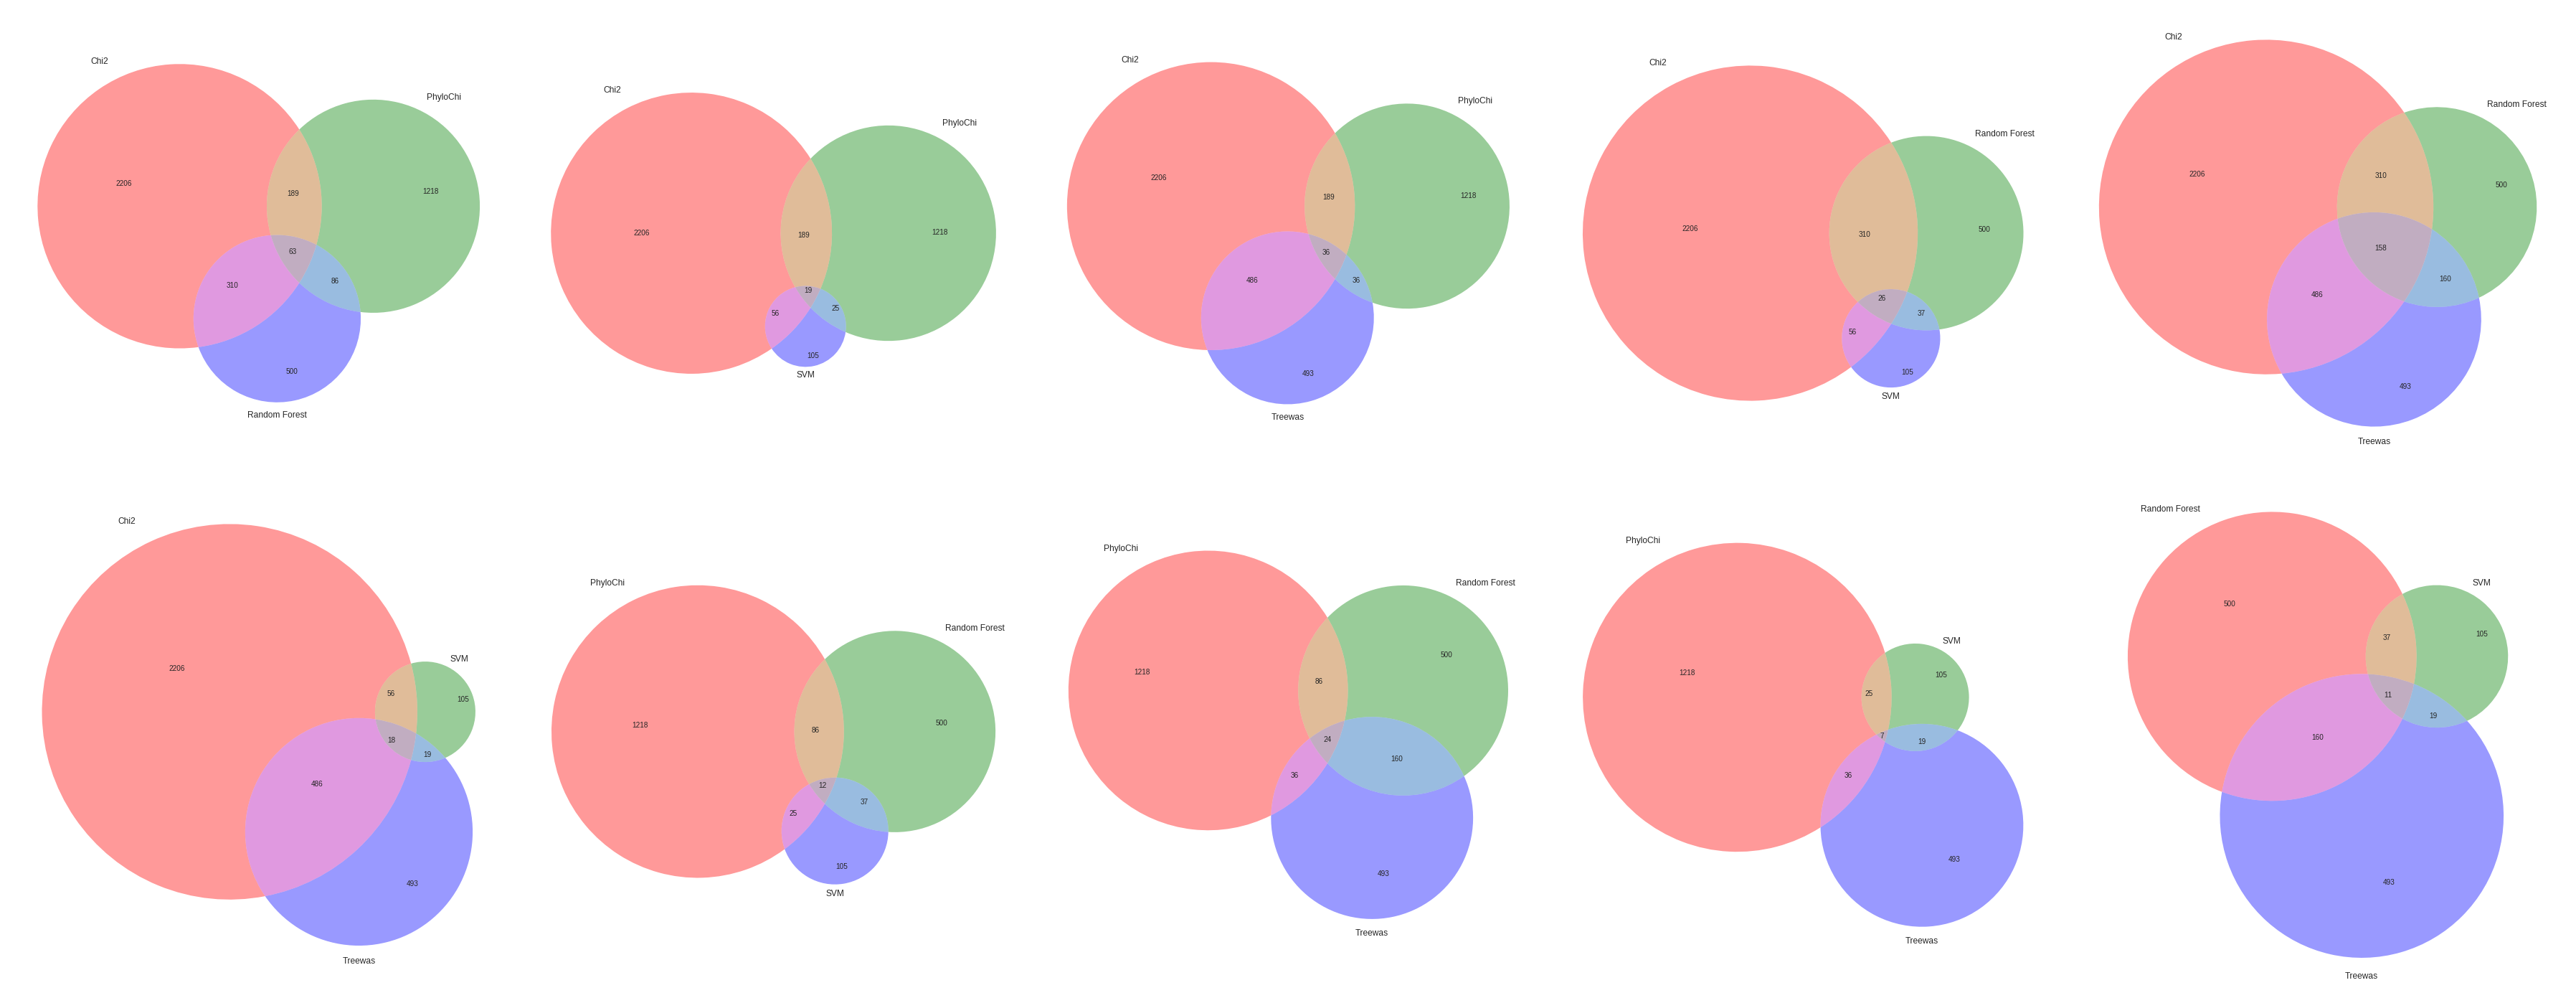

Tobramycin


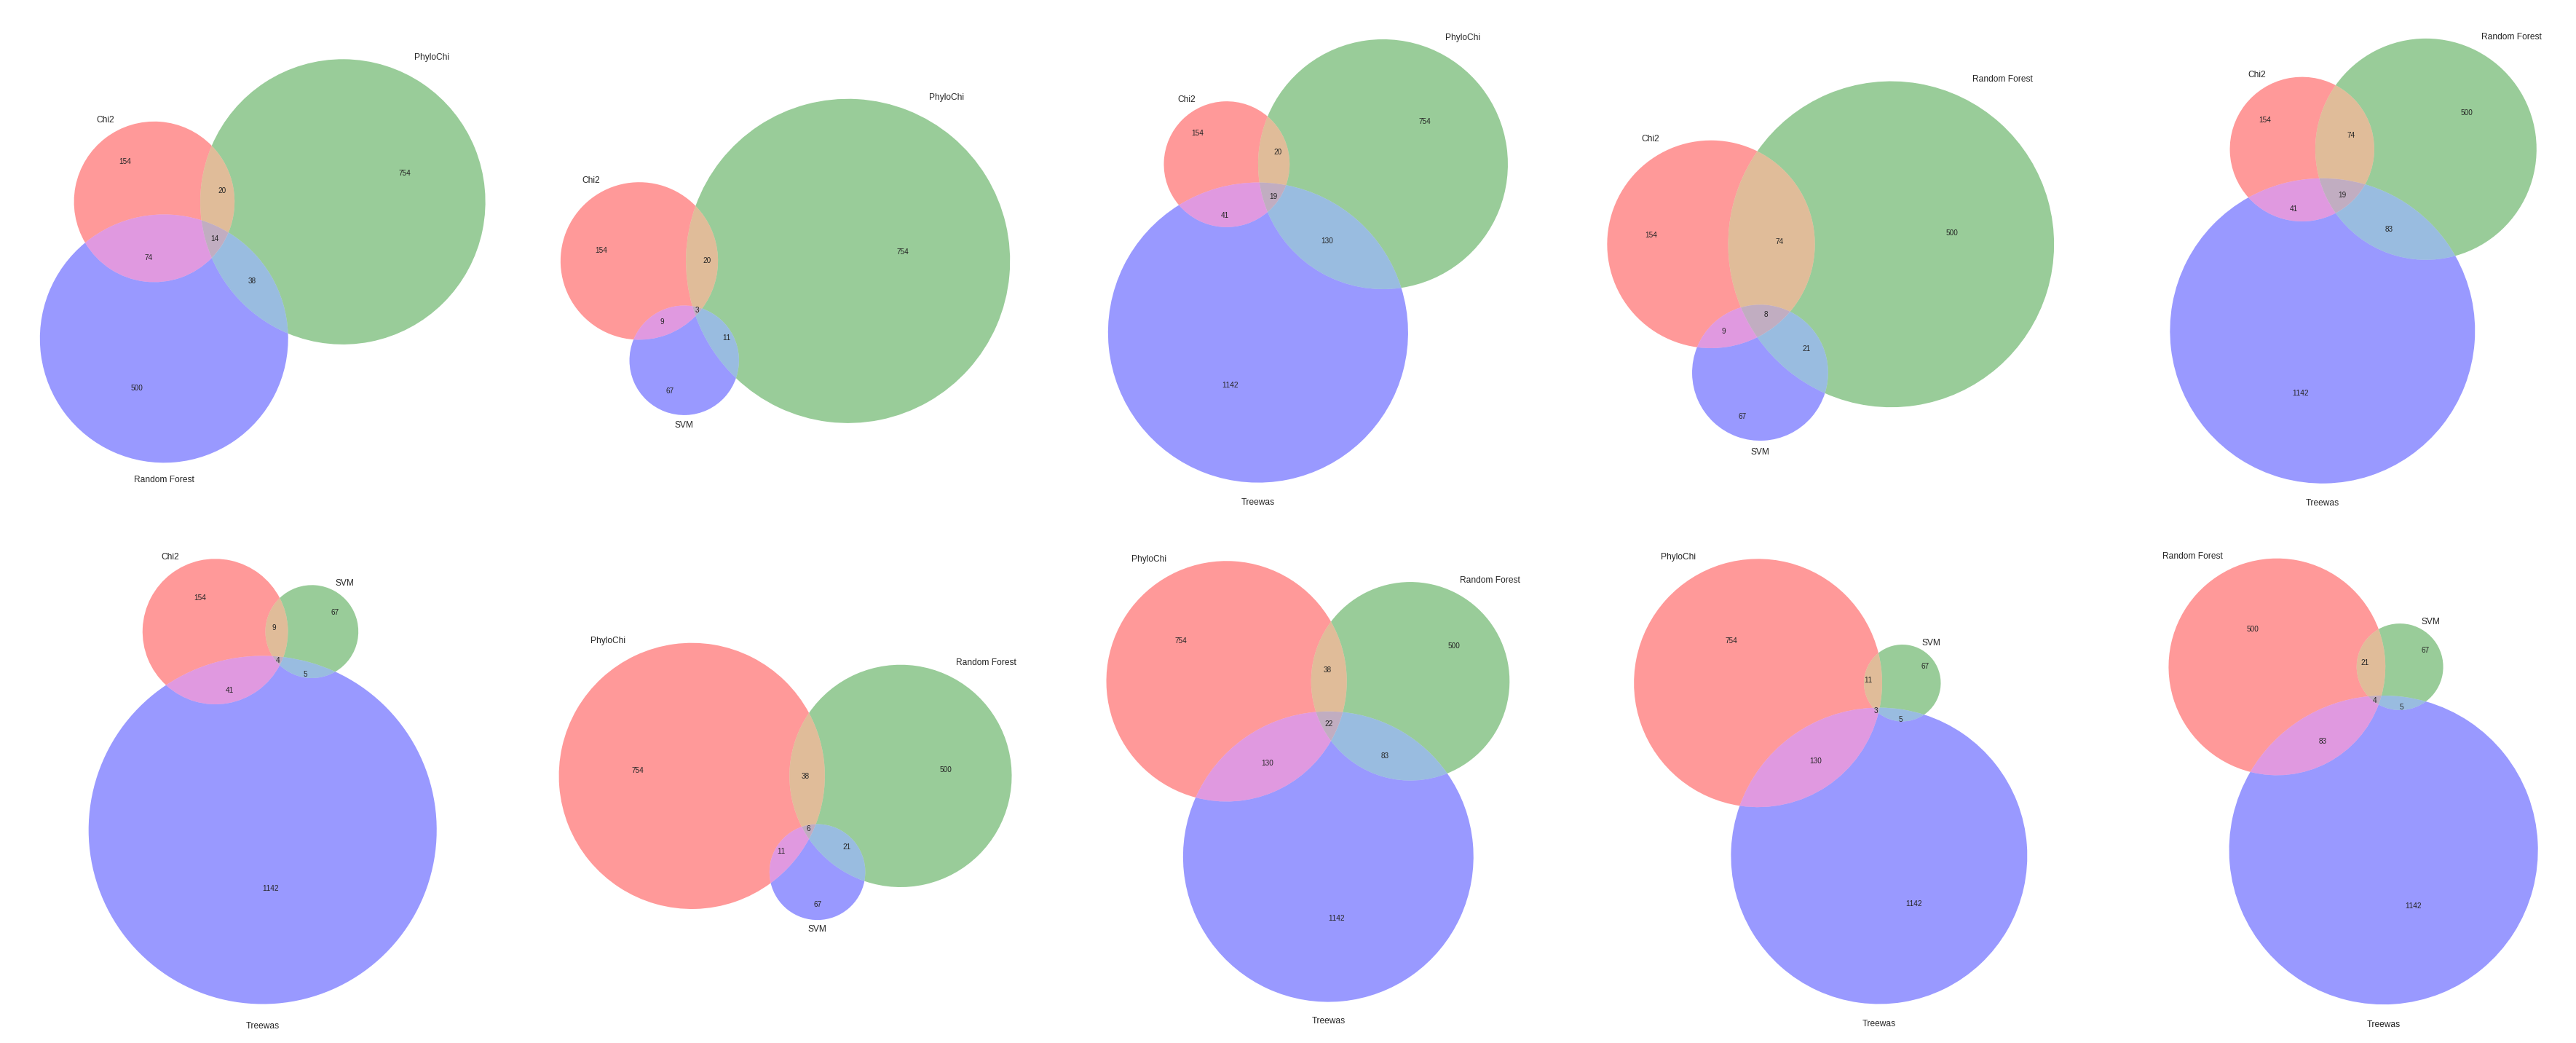

Meropenem


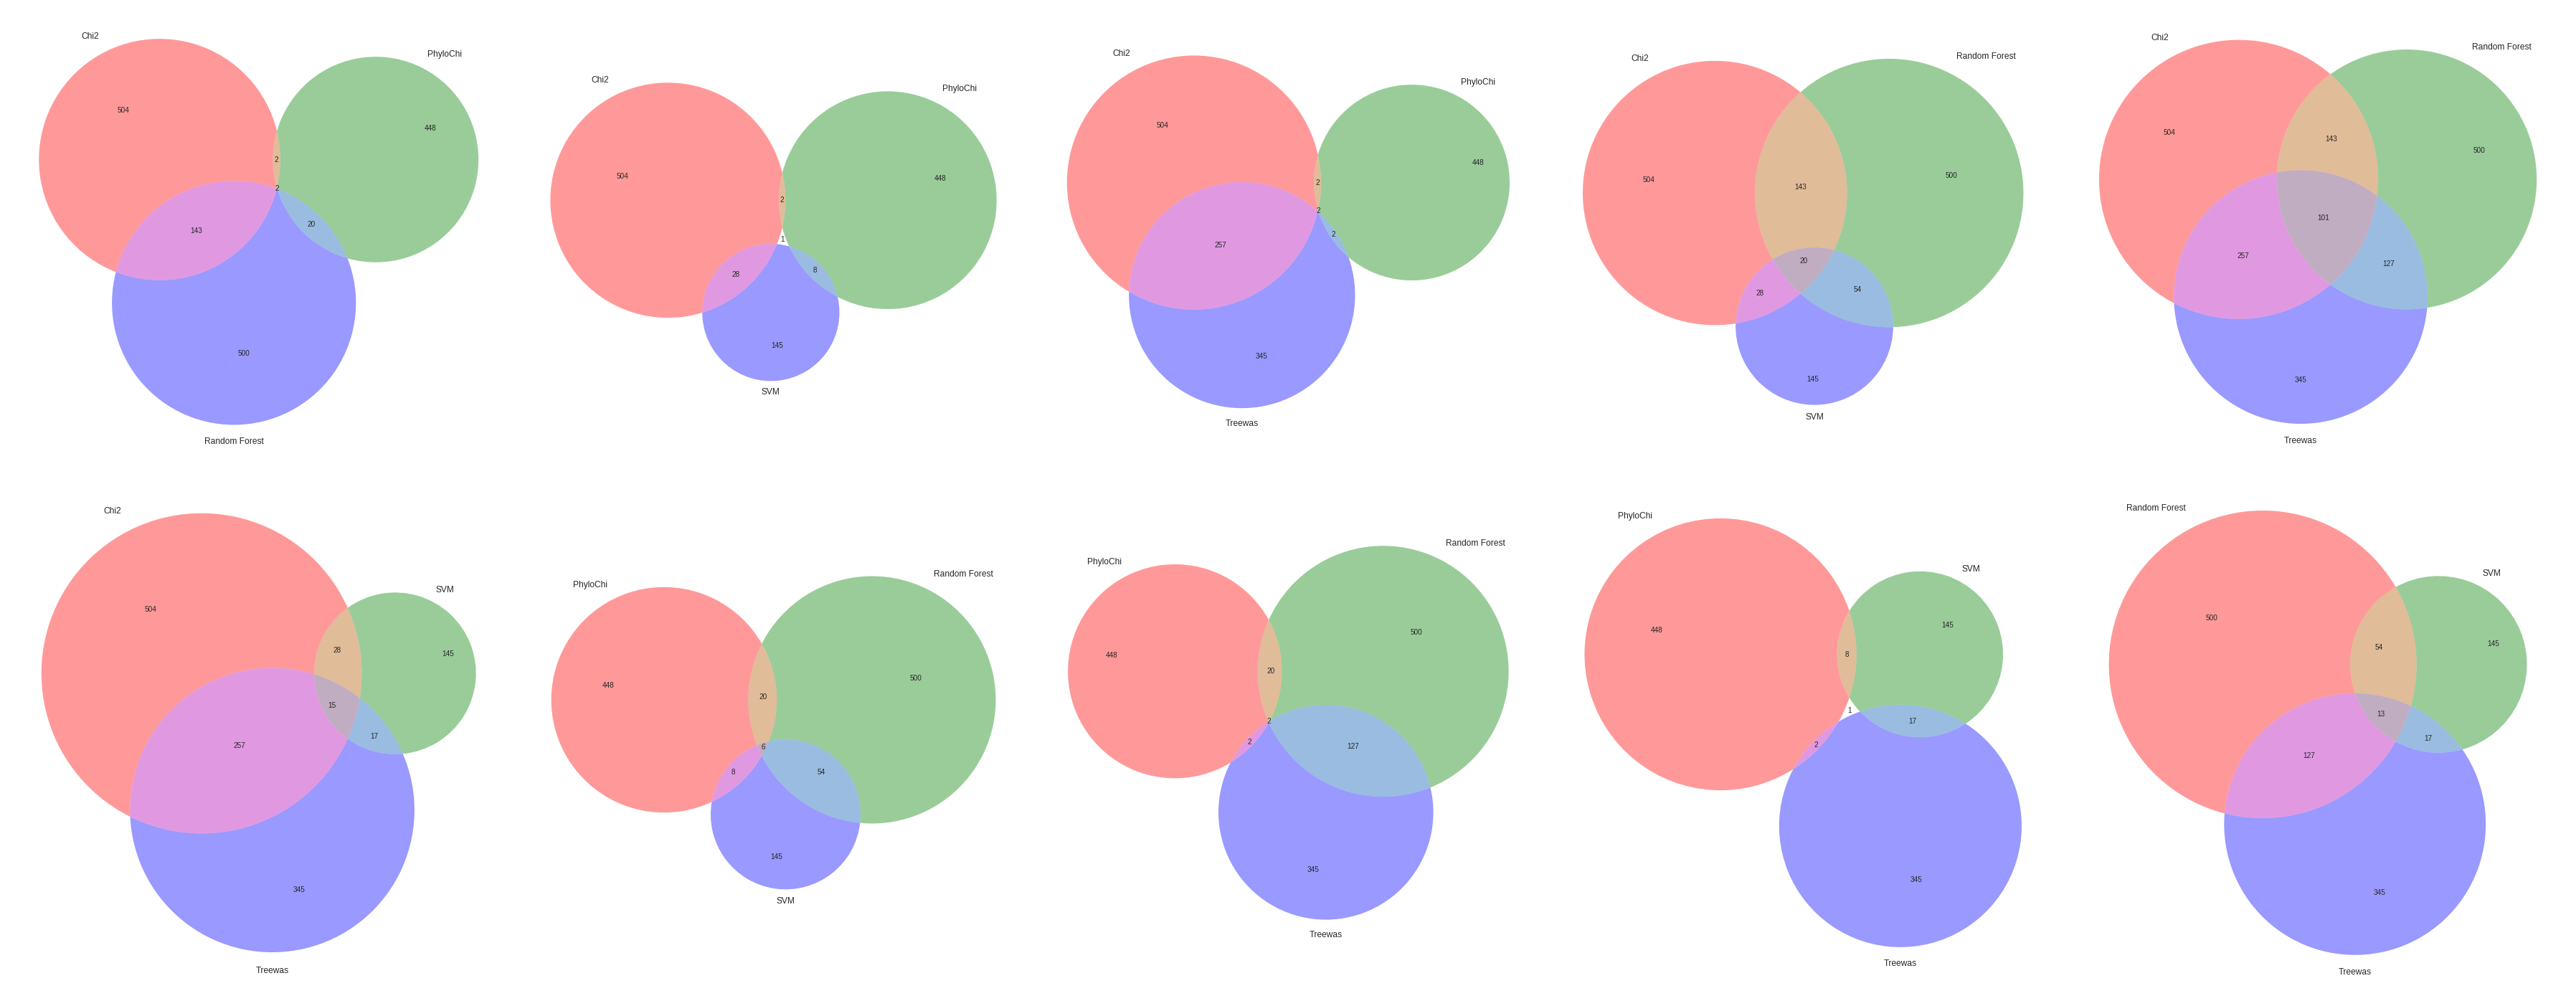

Ceftazidim


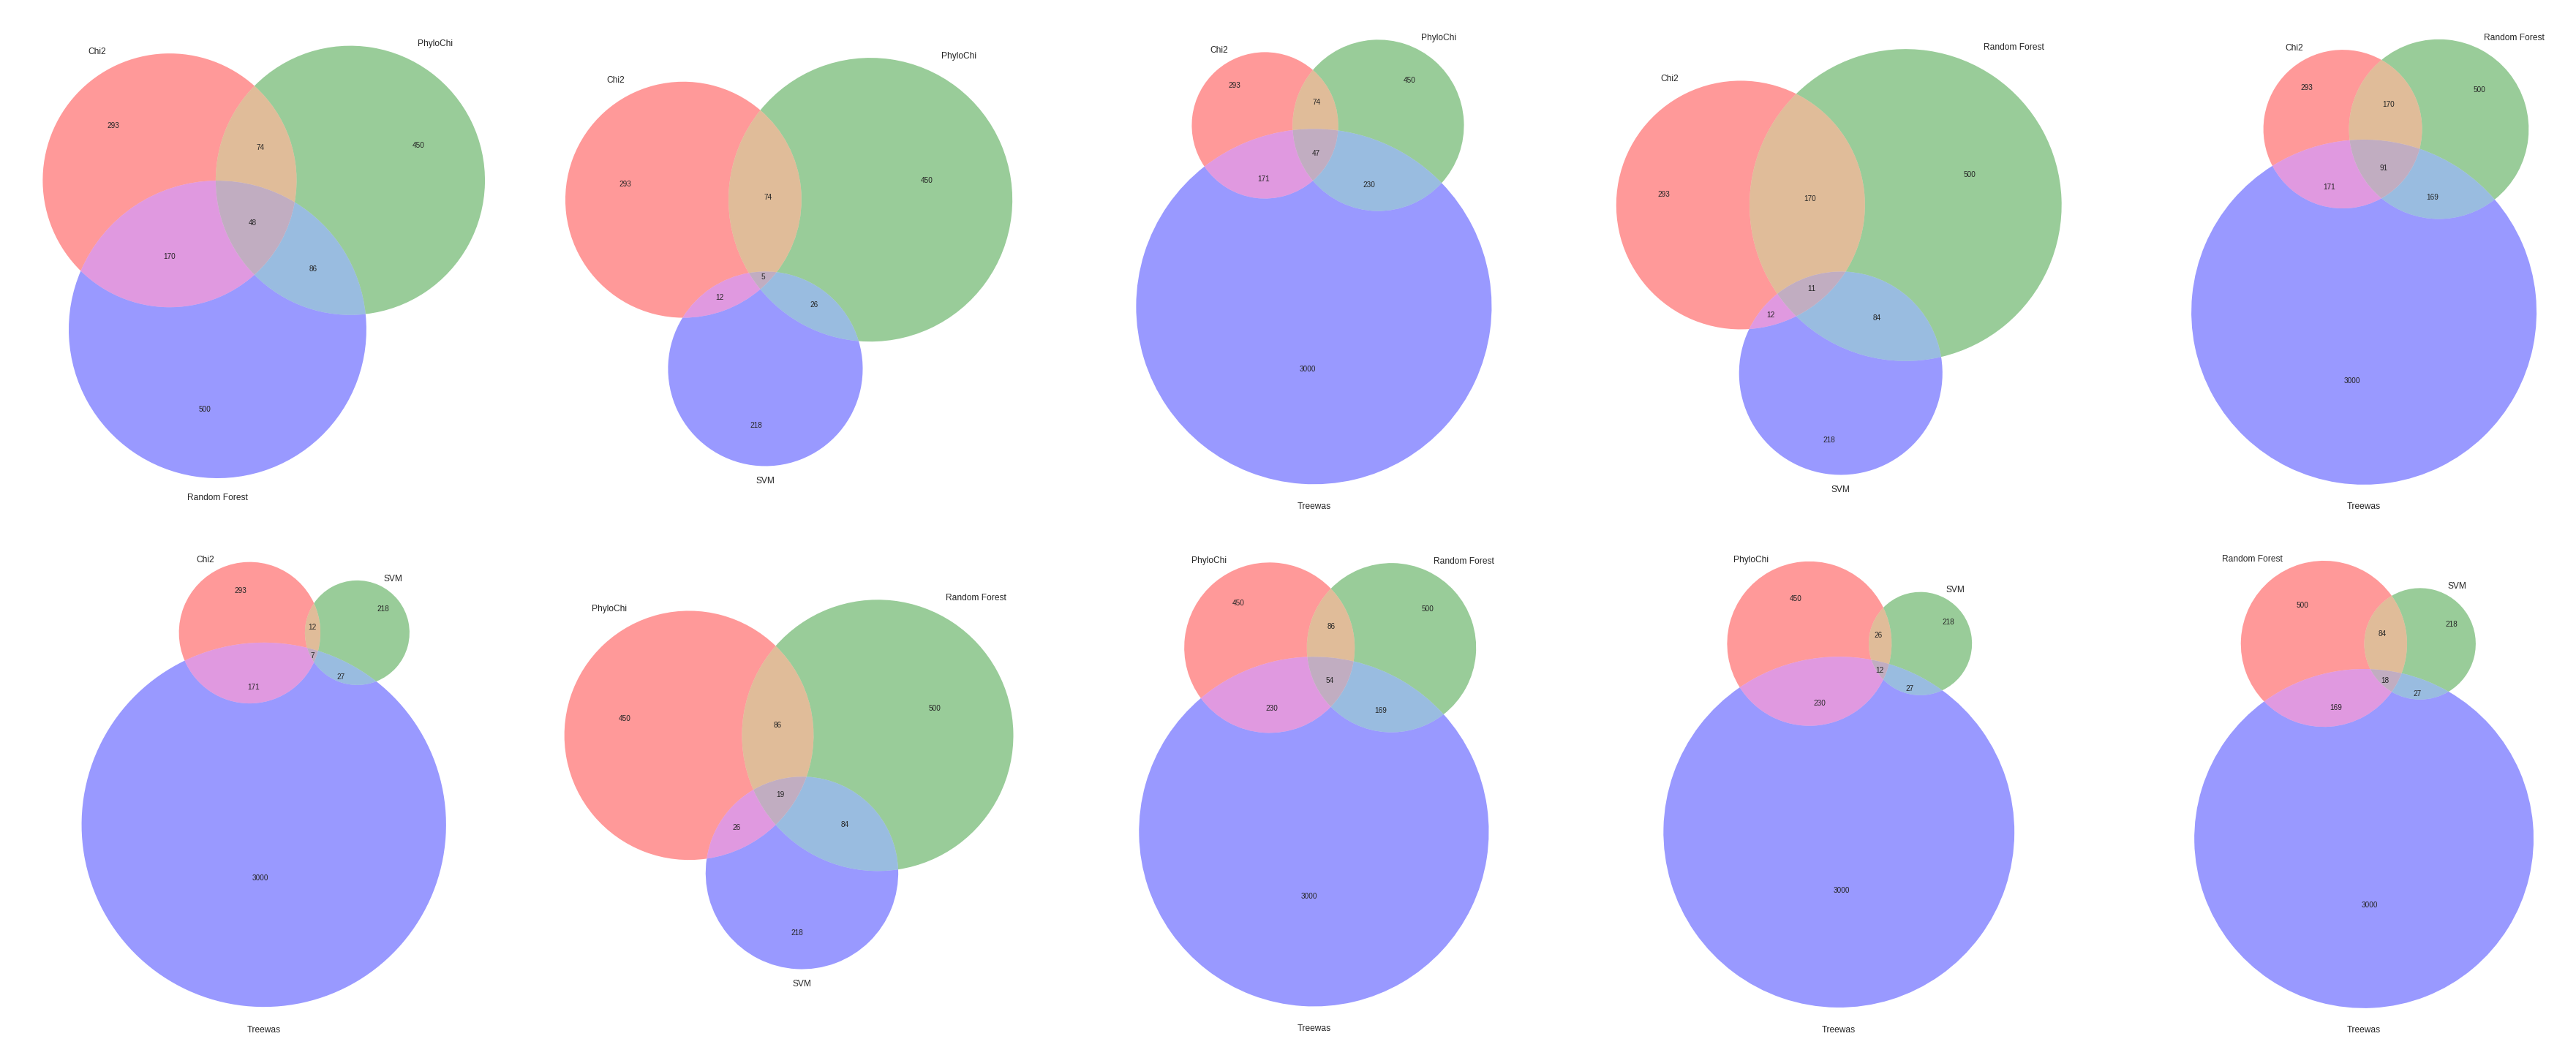

Colistin


In [10]:
accum_features_all=dict()
for drug, res_dict in  drug_method_features_scores_dict.items():
    accum_features=methods2venn(res_dict, '../../amr_results/features/aggregation/'+drug)
    print (drug)
    accum_features_all[drug]=accum_features

In [12]:
from nltk import FreqDist

final_list_with_vector_300=dict()
for drug, features in accum_features_all.items():
    l=FreqDist(features).most_common(300)
    print(drug)
    final_list_with_vector_300[drug]=[(feature, rep, [drug_method_features_scores_dict[drug][method][feature] if feature in drug_method_features_scores_dict[drug][method] else 0 for method in ['Chi2', 'PhyloChi','Random Forest', 'SVM', 'Treewas' ]]) for feature, rep in l]

Ciprofloxacin
Tobramycin
Meropenem
Ceftazidim
Colistin


Data access created..
@@@../../amr_results/res_before_5_3_2017/intermediate_reps/gpa_trimmed_feature_vect.npz
@@@../../amr_results/res_before_5_3_2017/intermediate_reps/gpa_roary_feature_vect.npz
Tobramycin  features  gpa_trimmed and gpa_roary  Random Forest 
Ceftazidim  features  gpa_trimmed and gpa_roary  Random Forest 
Ciprofloxacin  features  gpa_trimmed and gpa_roary  Random Forest 
Meropenem  features  gpa_trimmed and gpa_roary  Random Forest 
Colistin  features  gpa_trimmed and gpa_roary  Random Forest 


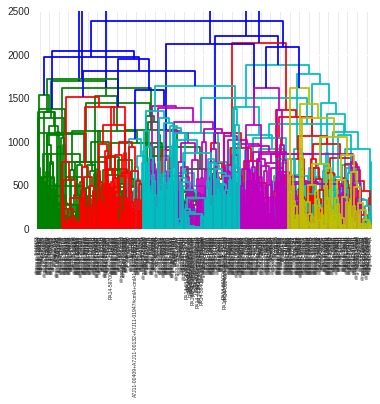

In [14]:
# create newick format
sys.path.append('../')
from data_access.data_access_utility import ABRDataAccess
from classifier.classical_classifiers import SVM, RFClassifier, KNN
from utility.file_utility import FileUtility
from sklearn.preprocessing import normalize
from clustering.hierarchical_clustering import HierarchicalClutering
from scipy import stats
from sklearn.preprocessing import normalize

feature_lists=[['gpa_trimmed','gpa_roary']]

for feature_list in feature_lists:
    ABRAccess=ABRDataAccess('../../amr_results/res_before_5_3_2017/intermediate_reps/',feature_list)
    for drug in ABRAccess.BasicDataObj.drugs:
        print(drug , ' features ',' and '.join(feature_list), ' Random Forest ')
        X_rep, Y, features, final_isolates = ABRAccess.get_xy_prediction_mats(drug, mapping={'0':0,'0.0':0,'1':1,'1.0':1})
        features=[feature.replace(' ','').replace('gpa_roary##','').replace('gpa_trimmed##','') for feature in features]
        selected=[x for x,y,z  in final_list_with_vector_300[drug]]
        selected_idx=[idx for idx, feature in enumerate(features) if feature in selected]
        selected_names=[features[idx].replace('_','-').replace(',','#') for idx in selected_idx]
        mat=normalize(X_rep[:,selected_idx].T.toarray()+1e-100, norm='l1')
        out = stats.entropy(mat.T[:,:,None], mat.T[:,None,:])
        HC=HierarchicalClutering(out, selected_names)
        out_nwk=HC.nwk
        FileUtility.save_list('../../amr_results/features/aggregation/nwk_'+drug,[out_nwk])

In [15]:
# create files for each drug
for drug in ['Ciprofloxacin', 'Tobramycin', 'Colistin', 'Ceftazidim', 'Meropenem']:
    for drug, features in final_list_with_vector_300.items():
        file_lines=['\t'.join(['feature', 'repeat', 'Chi2', 'PhyloChi','Random Forest', 'SVM', 'Treewas'])]
        for name, rep, vals in features:
            file_lines.append('\t'.join([name, str(rep)]+[str(x) for x in vals]))
        FileUtility.save_list('../../amr_results/features/aggregation/'+drug+'_top300.txt', file_lines)

# create matrix
from sklearn import preprocessing

for drug, features in final_list_with_vector_300.items():
    file_lines=['\t'.join(['feature', 'repeat', 'Chi2', 'PhyloChi','Random Forest', 'SVM', 'Treewas'])]
    mat=[]
    for name, rep, vals in features:
        mat.append([vals[0],vals[1],vals[2],vals[3],-np.log(vals[4]+0.0000000000001)])
    mat=np.array(mat)
    mat=preprocessing.scale(mat)
    np.savetxt('../../amr_results/features/aggregation/'+drug+'_scores',mat)

## mat dictionary
from sklearn import preprocessing

mat_dict=dict()
for drug, features in final_list_with_vector_300.items():
    file_lines=['\t'.join(['feature', 'repeat', 'Chi2', 'PhyloChi','Random Forest', 'SVM', 'Treewas'])]
    mat=[]
    for name, rep, vals in features:
        mat.append([vals[0],vals[1],vals[2],vals[3],-np.log(vals[4]+0.0000000000001)])
    mat=np.array(mat)
    mat=preprocessing.scale(mat)

    mat_dict[drug]={x.replace('_','-').replace(',','#'):mat[idx,:].tolist() for idx,(x,y,z)  in enumerate(features)}
    
FileUtility.save_obj('../../amr_results/features/aggregation/dictionary_scores',mat_dict)